In [1]:
import os

os.chdir("..")

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import joblib
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings("ignore")

# Evaluation
from sklearn.metrics import (
    f1_score,
    classification_report,
    confusion_matrix,
    make_scorer
)

# tf-idf
from sklearn.feature_extraction.text import TfidfVectorizer

# Other
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
from skmultilearn.model_selection import IterativeStratification

# Classifiers
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

from src.models.evaluation import evaluation
from src.data.iterative_train_test_split import iterative_train_test_split

Using TensorFlow backend.


In [3]:
pd.set_option("display.max_rows", 5)
pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", 100)

## 1. Load and transform data

In [4]:
# Load data
df = pd.read_pickle("data/processed/reports_tokenized.p")
df

,ID,Identifier,Company_Name,ISIN,Ticker,Country_of_Exchange,Financial_Period_Absolute,Financial_Period_Relative,CSR_URL,SDG_1,SDG_2,SDG_3,SDG_4,SDG_5,SDG_6,SDG_7,SDG_8,SDG_9,SDG_10,SDG_11,SDG_12,SDG_13,SDG_14,SDG_15,SDG_16,SDG_17,CSR_Filename,CSR_Text,CSR_Text_clean,CSR_Text_tokenized
0,0,888.L,888 Holdings PLC,GI000A0F6407,888,United Kingdom,2020,FY0,https://corporate.888.com/wp-content/uploads/2021/04/2020-Annual-Report.pdf,False,False,True,True,True,True,True,True,False,NaN,False,True,True,NaN,False,True,False,0_888.L_2020.pdf,888 HOLDINGS PLC\n\nANNUAL REPORT & ACCOUNTS 2020\n\n A YEAR OF \nSTRONG GROWTH \n\n888 IS ONE ...,888 ORG ANNUAL REPORT & ACCOUNTS 2020 A YEAR OF STRONG GROWTH ORG IS ONE OF THE WORLDS LEADING O...,org annual report account year strong growth org one world leading online betting gaming company...
1,1,A.N,Agilent Technologies Inc,US00846U1016,A,United States of America,2020,FY0,https://www.agilent.com/about/companyinfo/sustainability/Agilent-Report-CSR-2020.pdf,False,False,True,True,True,True,True,True,False,NaN,False,True,True,NaN,True,True,False,1_A.N_2020.pdf,Delivering on \nour Promises\n\n2020 Corporate Social Responsibility Report\n\n1\n\n Letter fro...,Delivering on our Promises 2020 Corporate ORG 1 Letter from the President Stakeholder engagement...,delivering promise corporate org letter president stakeholder engagement environment table conte...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8101,8101,ZBH.N,Zimmer Biomet Holdings Inc,US98956P1021,ZBH,United States of America,2016,FY-4,https://www.responsibilityreports.com/HostedData/ResponsibilityReportArchive/z/NYSE_ZBH_2016.pdf,False,False,True,True,True,True,True,True,False,NaN,False,True,False,NaN,False,True,False,12676_ZBH.N_2016.pdf,E N V I R O N M E N T A L \n\n \n\nS O C I A L \n\nG O V E R N A N C E\n\nSustainability \nRep...,E N V I R O N M E N T A L S O C I A L G O V E R N A N C E Sustainability Report 2016 T A B L E O...,sustainability report company profile corporate overview purpose mission value sustainability co...
8102,8102,ZBH.N,Zimmer Biomet Holdings Inc,US98956P1021,ZBH,United States of America,2015,FY-5,https://www.responsibilityreports.com/HostedData/ResponsibilityReportArchive/z/NYSE_ZBH_2015.pdf,False,False,True,True,False,True,True,False,False,NaN,False,True,False,NaN,False,False,False,12677_ZBH.N_2015.pdf,E N V I R O N M E N T A L \n\n \n\nS O C I A L \n\nG O V E R N A N C E\n\nSustainability \nRep...,E N V I R O N M E N T A L S O C I A L G O V E R N A N C E Sustainability Report 2015 Investing n...,sustainability report investing future world letter ceo stakeholder company profile corporate ov...


In [5]:
# Transform labels to numpy array: Exclude SDGs 2 and 9 (too few aligned examples) and 10 and 14 (no mapping) -> 13 labels left
labels = [
    "SDG_1",
    "SDG_3",
    "SDG_4",
    "SDG_5",
    "SDG_6",
    "SDG_7",
    "SDG_8",
    "SDG_11",
    "SDG_12",
    "SDG_13",
    "SDG_15",
    "SDG_16",
    "SDG_17",
]
Y = df[labels].to_numpy().astype(int)

## 2. Create features

In [70]:
# Keywords from NLP for SDGs paper

keywords_sdg1 = [
    "social",
    "end poverty",
    "poverty dimension",
    "poverty",
    "social protection",
    "poor",
    "unemployed person",
    "poverty line",
    "protection",
    "cash benefit",
    "extreme poverty",
    "poor vulnerable",
    "humanitarian",
    "vulnerable",
]

keywords_sdg3 = [
    "life expectancy",
    "mental health",
    "air pollution",
    "medicine vaccine",
    "infectious disease",
    "good health",
    "respiratory disease",
    "reproductive health",
    "mortality",
    "healthcare",
    "disease diabetes",
    "disease",
    "health coverage",
    "health",
    "maternal mortality",
    "death preventable",
    "cardiovascular disease",
]

keywords_sdg4 = [
    "teacher",
    "secondary school",
    "proficiency level",
    "primary school",
    "inclusive",
    "literacy",
    "literacy numeracy",
    "higher education",
    "quality education",
    "school",
    "effective learn",
    "vocational train",
    "level proficiency",
    "minimum proficiency",
    "technical vocational",
]

keywords_sdg5 = [
    "domestic work",
    "right",
    "sexual violence",
    "woman",
    "girl",
    "discrimination",
    "reproductive health",
    "managerial position",
    "woman girl",
    "marriage",
    "woman representation",
    "gender equality",
    "gender parity",
    "child marriage",
    "gender",
]

keywords_sdg6 = [
    "water sanitation",
    "drink water",
    "sanitation",
    "basic drink",
    "wastewater",
    "water scarcity",
    "hygiene",
    "water",
    "sanitation service",
    "sanitation hygiene",
    "supply freshwater",
    "handwash facility",
    "resource management",
    "water stress",
]

keywords_sdg7 = [
    "energy",
    "technology",
    "renewable energy",
    "infrastructure",
    "electricity",
    "cheap energy",
    "solar",
    "solar power",
    "wind power",
    "thermal power",
    "energy productivity",
    "energy efficiency",
    "greenhouse gases",
    "greenhouse",
    "fossil fuels",
    "pollution",
    "energy standards",
    "energy access",
    "energy consumption",
    "access electricity",
    "without electricity",
    "fuel technology",
    "fossil fuel",
]

keywords_sdg8 = [
    "labor",
    "employment",
    "gdp",
    "job",
    "unemployed",
    "economic growth",
    "productivity",
    "job creation",
    "slavery",
    "forced labor",
    "labor force",
    "women participation",
    "labor organization",
    "human right",
    "informal employment",
    "growth rate",
    "labour productivity",
    "decent work",
    "secure work",
    "global economic",
    "gender pay",
    "crisis level",
    "rate real",
    "decent work",
    "education employment",
    "slavery human",
    "child labour",
    "youth employment",
]

keywords_sdg11 = [
    "city",
    "urban",
    "urban population",
    "public",
    "disability",
    "disaster",
    "sustainable city",
    "affordable housing",
    "housing access",
    "resilient societies",
    "public transport",
    "public spaces",
    "urban planning",
    "inclusive",
    "business opportunities",
    "sustainable development",
    "person disability",
    "green public",
    "sustainable resilient",
    "sustainable urbanization",
    "population convenient",
    "convenient access",
]

keywords_sdg12 = [
    "responsible consumption",
    "sustainable development",
    "resources",
    "consumption",
    "production",
    "development",
    "reduce waste",
    "efficient",
    "efficient economy",
    "energy consumption",
    "energy efficient",
    "supporting developing",
    "material footprint",
    "natural resource",
    "recycle",
    "sustainable consumption",
    "domestic material",
    "consumption production",
    "food waste",
]

keywords_sdg13 = [
    "climate",
    "develop",
    "disaster",
    "local",
    "emissions reductions",
    "global warm",
    "climate change",
    "climate system",
    "greenhouse gas",
    "emissions",
    "co2 emissions",
    "low carbon",
    "disaster risk",
    "sustainable management",
    "natural resource",
    "sea levels",
    "sustainable energy",
    "paris agreement",
    "sustainable energy",
    "climate relate",
    "green climate",
    "disaster risk",
]

keywords_sdg15 = [
    "land degradation",
    "terrestrial freshwater",
    "ecosystem",
    "deforestation",
    "specie animal",
    "forest management",
    "biodiversity",
    "conservation",
    "protect area",
    "forest",
    "terrestrial",
    "species",
    "wildlife",
    "protect",
    "agriculture",
    "land",
    "area",
]

keywords_sdg16 = [
    "law",
    "human right",
    "right violation",
    "insecurity",
    "institution",
    "violence",
    "exploitation",
    "global governance",
    "transparency",
    "rule",
    "corruption bribery",
    "access justice",
    "corruption",
    "justice",
    "peace",
    "conflict violence",
    "international",
    "victim human",
    "conflict",
]

keywords_sdg17 = [
    "sustainable development",
    "innovation",
    "enhance international",
    "official development",
    "capacity build",
    "development",
    "coordinate policy",
    "develop country",
    "assistance",
    "cooperation",
    "international support",
    "international cooperation",
    "partnership",
    "international",
    "policy coherence",
    "development assistance",
    "country",
]

keywords = keywords_sdg1 + keywords_sdg3 + keywords_sdg4 + keywords_sdg5 + keywords_sdg6 + keywords_sdg7 + keywords_sdg8 + keywords_sdg11 + keywords_sdg12 + keywords_sdg13 + keywords_sdg15 + keywords_sdg16 + keywords_sdg17

print('There are ' + str(len(keywords)) + ' keywords')

There are 242 keywords


In [71]:
# Initialize new dataframe to store counts of each keyword for each CSR
df_features = df.drop(columns=['CSR_Text', 'CSR_Text_clean'])

for word in keywords:
    df_features[word] = 0
    
df_features

,ID,Identifier,Company_Name,ISIN,Ticker,Country_of_Exchange,Financial_Period_Absolute,Financial_Period_Relative,CSR_URL,SDG_1,SDG_2,SDG_3,SDG_4,SDG_5,SDG_6,SDG_7,SDG_8,SDG_9,SDG_10,SDG_11,SDG_12,SDG_13,SDG_14,SDG_15,SDG_16,SDG_17,CSR_Filename,CSR_Text_tokenized,social,end poverty,poverty dimension,poverty,social protection,poor,unemployed person,poverty line,protection,cash benefit,extreme poverty,poor vulnerable,humanitarian,vulnerable,life expectancy,mental health,air pollution,medicine vaccine,infectious disease,good health,respiratory disease,reproductive health,mortality,healthcare,disease diabetes,disease,health coverage,health,maternal mortality,death preventable,cardiovascular disease,teacher,secondary school,proficiency level,primary school,inclusive,literacy,literacy numeracy,higher education,quality education,school,effective learn,vocational train,level proficiency,minimum proficiency,technical vocational,domestic work,right,sexual violence,woman,girl,discrimination,managerial position,woman girl,marriage,woman representation,gender equality,gender parity,child marriage,gender,water sanitation,drink water,sanitation,basic drink,wastewater,water scarcity,hygiene,water,sanitation service,sanitation hygiene,supply freshwater,handwash facility,resource management,water stress,energy,technology,renewable energy,infrastructure,electricity,cheap energy,solar,solar power,wind power,thermal power,energy productivity,energy efficiency,greenhouse gases,greenhouse,fossil fuels,pollution,energy standards,energy access,energy consumption,access electricity,without electricity,fuel technology,fossil fuel,labor,employment,gdp,job,unemployed,economic growth,productivity,job creation,slavery,forced labor,labor force,women participation,labor organization,human right,informal employment,growth rate,labour productivity,decent work,secure work,global economic,gender pay,crisis level,rate real,education employment,slavery human,child labour,youth employment,city,urban,urban population,public,disability,disaster,sustainable city,affordable housing,housing access,resilient societies,public transport,public spaces,urban planning,business opportunities,sustainable development,person disability,green public,sustainable resilient,sustainable urbanization,population convenient,convenient access,responsible consumption,resources,consumption,production,development,reduce waste,efficient,efficient economy,energy efficient,supporting developing,material footprint,natural resource,recycle,sustainable consumption,domestic material,consumption production,food waste,climate,develop,local,emissions reductions,global warm,climate change,climate system,greenhouse gas,emissions,co2 emissions,low carbon,disaster risk,sustainable management,sea levels,sustainable energy,paris agreement,climate relate,green climate,land degradation,terrestrial freshwater,ecosystem,deforestation,specie animal,forest management,biodiversity,conservation,protect area,forest,terrestrial,species,wildlife,protect,agriculture,land,area,law,right violation,insecurity,institution,violence,exploitation,global governance,transparency,rule,corruption bribery,access justice,corruption,justice,peace,conflict violence,international,victim human,conflict,innovation,enhance international,official development,capacity build,coordinate policy,develop country,assistance,cooperation,international support,international cooperation,partnership,policy coherence,development assistance,country
0,0,888.L,888 Holdings PLC,GI000A0F6407,888,United Kingdom,2020,FY0,https://corporate.888.com/wp-content/uploads/2021/04/2020-Annual-Report.pdf,False,False,True,True,True,True,True,True,False,NaN,False,True,True,NaN,False,True,False,0_888.L_2020.pdf,org annual report account year strong growth org one world leading online betting gaming company...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [72]:
# Count occurence of each keyword in each CSR

for index, row in tqdm(df_features.iterrows()):
    for word in keywords:
        df_features.loc[index, word] = df_features.loc[index, 'CSR_Text_tokenized'].count(word)

df_features

0it [00:00, ?it/s]

,ID,Identifier,Company_Name,ISIN,Ticker,Country_of_Exchange,Financial_Period_Absolute,Financial_Period_Relative,CSR_URL,SDG_1,SDG_2,SDG_3,SDG_4,SDG_5,SDG_6,SDG_7,SDG_8,SDG_9,SDG_10,SDG_11,SDG_12,SDG_13,SDG_14,SDG_15,SDG_16,SDG_17,CSR_Filename,CSR_Text_tokenized,social,end poverty,poverty dimension,poverty,social protection,poor,unemployed person,poverty line,protection,cash benefit,extreme poverty,poor vulnerable,humanitarian,vulnerable,life expectancy,mental health,air pollution,medicine vaccine,infectious disease,good health,respiratory disease,reproductive health,mortality,healthcare,disease diabetes,disease,health coverage,health,maternal mortality,death preventable,cardiovascular disease,teacher,secondary school,proficiency level,primary school,inclusive,literacy,literacy numeracy,higher education,quality education,school,effective learn,vocational train,level proficiency,minimum proficiency,technical vocational,domestic work,right,sexual violence,woman,girl,discrimination,managerial position,woman girl,marriage,woman representation,gender equality,gender parity,child marriage,gender,water sanitation,drink water,sanitation,basic drink,wastewater,water scarcity,hygiene,water,sanitation service,sanitation hygiene,supply freshwater,handwash facility,resource management,water stress,energy,technology,renewable energy,infrastructure,electricity,cheap energy,solar,solar power,wind power,thermal power,energy productivity,energy efficiency,greenhouse gases,greenhouse,fossil fuels,pollution,energy standards,energy access,energy consumption,access electricity,without electricity,fuel technology,fossil fuel,labor,employment,gdp,job,unemployed,economic growth,productivity,job creation,slavery,forced labor,labor force,women participation,labor organization,human right,informal employment,growth rate,labour productivity,decent work,secure work,global economic,gender pay,crisis level,rate real,education employment,slavery human,child labour,youth employment,city,urban,urban population,public,disability,disaster,sustainable city,affordable housing,housing access,resilient societies,public transport,public spaces,urban planning,business opportunities,sustainable development,person disability,green public,sustainable resilient,sustainable urbanization,population convenient,convenient access,responsible consumption,resources,consumption,production,development,reduce waste,efficient,efficient economy,energy efficient,supporting developing,material footprint,natural resource,recycle,sustainable consumption,domestic material,consumption production,food waste,climate,develop,local,emissions reductions,global warm,climate change,climate system,greenhouse gas,emissions,co2 emissions,low carbon,disaster risk,sustainable management,sea levels,sustainable energy,paris agreement,climate relate,green climate,land degradation,terrestrial freshwater,ecosystem,deforestation,specie animal,forest management,biodiversity,conservation,protect area,forest,terrestrial,species,wildlife,protect,agriculture,land,area,law,right violation,insecurity,institution,violence,exploitation,global governance,transparency,rule,corruption bribery,access justice,corruption,justice,peace,conflict violence,international,victim human,conflict,innovation,enhance international,official development,capacity build,coordinate policy,develop country,assistance,cooperation,international support,international cooperation,partnership,policy coherence,development assistance,country
0,0,888.L,888 Holdings PLC,GI000A0F6407,888,United Kingdom,2020,FY0,https://corporate.888.com/wp-content/uploads/2021/04/2020-Annual-Report.pdf,False,False,True,True,True,True,True,True,False,NaN,False,True,True,NaN,False,True,False,0_888.L_2020.pdf,org annual report account year strong growth org one world leading online betting gaming company...,28,0,0,0,0,1,0,0,33,0,0,0,0,7,0,1,0,0,0,0,0,0,0,0,0,0,0,19,0,0,0,0,0,0,0,5,0,0,0,0,0,0,0,0,0,0,0,58,0,6,0,5,1,0,0,1,0,0,0,8,0,0,0,0,0,0,0,5,0,0,0,0,1,0,12,46,0,6,0,0,

In [82]:
# Split into 70% training, 15% validation, and 15% test data (stratified for multi-label, adapted to work with df column)

np.random.seed(7)

X_train, Y_train, X_test, Y_test = iterative_train_test_split(df_features[df_features.columns[28:]], Y, test_size=0.3)
X_val, Y_val, X_test, Y_test = iterative_train_test_split(X_test, Y_test, test_size=0.5)

## 2. Classification with balanced weights

### 2.1. Logistic Regression

In [88]:
np.random.seed(7)

# Pipeline
pipeline = Pipeline([
    ('clf', OneVsRestClassifier(LogisticRegression(class_weight="balanced", solver="liblinear")))
])
    
# Parameters to test in Grid Search
parameters = {
    'clf__estimator__C': [0.1, 1, 10] # Inverse of regularization strength, smaller values specify stronger regularization
}

# Use stratified sampling in each iteration
stratified_k_fold_cv = IterativeStratification(n_splits=5, order=1)
# Optimize for macro F1-score
scorer = make_scorer(f1_score, average="macro")

# Grid Search
grid_lr = GridSearchCV(pipeline, parameters, cv=stratified_k_fold_cv, scoring=scorer, n_jobs=8, verbose=3)
grid_lr.fit(X_train, Y_train)

# Print results
print("Best Parameters: {}".format(grid_lr.best_params_))
print("Mean cross-validated F1-score of the best estimator: {}".format(grid_lr.best_score_))

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   6 out of  15 | elapsed:   37.7s remaining:   56.6s
[Parallel(n_jobs=8)]: Done  12 out of  15 | elapsed:   58.4s remaining:   14.6s
[Parallel(n_jobs=8)]: Done  15 out of  15 | elapsed:  1.1min finished


Best Parameters: {'clf__estimator__C': 1}
Mean cross-validated F1-score of the best estimator: 0.708868340546276


              precision    recall  f1-score   support

           0       0.39      0.66      0.49       156
           1       0.93      0.66      0.77      1077
           2       0.88      0.57      0.70      1041
           3       0.92      0.65      0.76       981
           4       0.92      0.60      0.73      1011
           5       0.89      0.57      0.70       958
           6       0.90      0.64      0.74       899
           7       0.38      0.63      0.47       153
           8       0.96      0.63      0.76      1116
           9       0.85      0.57      0.68       828
          10       0.78      0.66      0.71       472
          11       0.90      0.64      0.75       930
          12       0.38      0.63      0.47       153

   micro avg       0.84      0.62      0.71      9775
   macro avg       0.78      0.62      0.67      9775
weighted avg       0.88      0.62      0.72      9775
 samples avg       0.72      0.57      0.60      9775



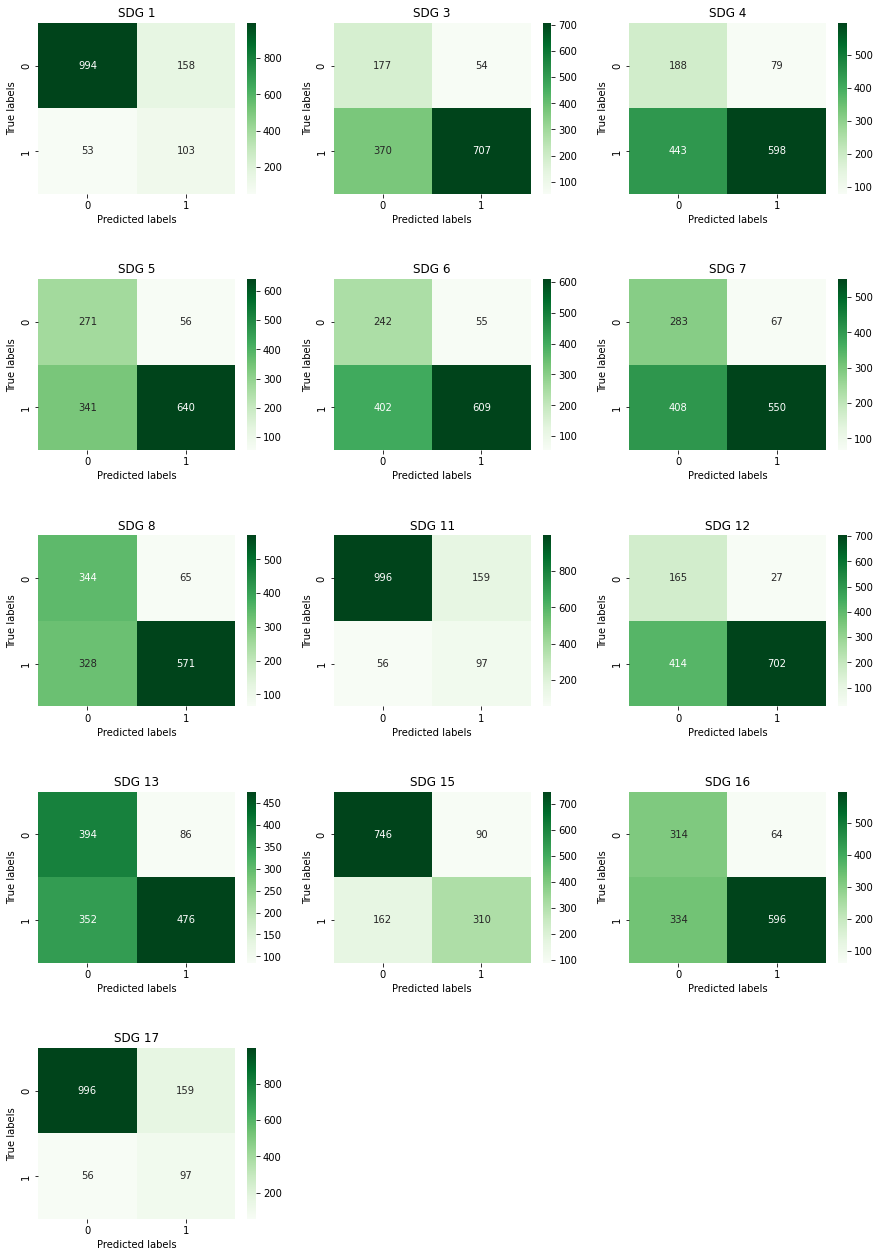

In [89]:
evaluation(grid_lr, X_test, Y_test)

### 2.2. Linear SVM

In [90]:
np.random.seed(7)

# Pipeline
pipeline = Pipeline([
    ('clf', OneVsRestClassifier(SVC(kernel='linear', class_weight="balanced")))
])
    
# Parameters to test in Grid Search
parameters = {
    'clf__estimator__C': [0.1, 1, 10] # Inverse of regularization strength, smaller values specify stronger regularization
}

# Use stratified sampling in each iteration
stratified_k_fold_cv = IterativeStratification(n_splits=5, order=1)
# Optimize for macro F1-score
scorer = make_scorer(f1_score, average="macro")

# Grid Search
grid_svm = GridSearchCV(pipeline, parameters, cv=stratified_k_fold_cv, scoring=scorer, n_jobs=8, verbose=3)
grid_svm.fit(X_train, Y_train)

# Print results
print("Best Parameters: {}".format(grid_svm.best_params_))
print("Mean cross-validated F1-score of the best estimator: {}".format(grid_svm.best_score_))

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   6 out of  15 | elapsed: 81.2min remaining: 121.8min


[CV] clf__estimator__C=1 .............................................
[CV] ................. clf__estimator__C=1, score=0.719, total=  14.5s
[CV] clf__estimator__C=10 ............................................
[CV] ................ clf__estimator__C=10, score=0.694, total=  29.6s
[CV] clf__estimator__C=1 .............................................
[CV] ................. clf__estimator__C=1, score=0.707, total=89.8min


Using TensorFlow backend.
/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV] clf__estimator__C=1 .............................................
[CV] ................. clf__estimator__C=1, score=0.715, total=  14.7s
[CV] clf__estimator__C=0.1 ...........................................
[CV] ............... clf__estimator__C=0.1, score=0.715, total= 7.4min
[CV] clf__estimator__C=1 .............................................
[CV] ................. clf__estimator__C=1, score=0.689, total=85.3min


Using TensorFlow backend.


[CV] clf__estimator__C=0.1 ...........................................
[CV] ............... clf__estimator__C=0.1, score=0.698, total=   6.7s
[CV] clf__estimator__C=10 ............................................
[CV] ................ clf__estimator__C=10, score=0.706, total=  27.4s
[CV] clf__estimator__C=0.1 ...........................................
[CV] ............... clf__estimator__C=0.1, score=0.695, total= 7.4min
[CV] clf__estimator__C=1 .............................................
[CV] ................. clf__estimator__C=1, score=0.695, total=93.5min


Using TensorFlow backend.
/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV] clf__estimator__C=0.1 ...........................................
[CV] ............... clf__estimator__C=0.1, score=0.716, total=   6.2s
[CV] clf__estimator__C=1 .............................................
[CV] ................. clf__estimator__C=1, score=0.703, total=  15.7s
[CV] clf__estimator__C=0.1 ...........................................
[CV] ............... clf__estimator__C=0.1, score=0.709, total= 7.6min
[CV] clf__estimator__C=10 ............................................
[CV] ............... clf__estimator__C=10, score=0.710, total=924.6min


Using TensorFlow backend.
/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
[Parallel(n_jobs=8)]: Done  12 out of  15 | elapsed: 1013.1min remaining: 253.3min


[CV] clf__estimator__C=0.1 ...........................................
[CV] ............... clf__estimator__C=0.1, score=0.700, total=   6.8s
[CV] clf__estimator__C=10 ............................................
[CV] ................ clf__estimator__C=10, score=0.714, total=  28.2s
[CV] clf__estimator__C=0.1 ...........................................
[CV] ............... clf__estimator__C=0.1, score=0.695, total= 7.6min
[CV] clf__estimator__C=10 ............................................
[CV] .............. clf__estimator__C=10, score=0.698, total=1005.5min


Using TensorFlow backend.
/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/home/jbaumert

[CV] clf__estimator__C=1 .............................................
[CV] ................. clf__estimator__C=1, score=0.710, total=  14.6s
[CV] clf__estimator__C=10 ............................................
[CV] ................ clf__estimator__C=10, score=0.701, total=  29.0s
[CV] clf__estimator__C=1 .............................................
[CV] ................. clf__estimator__C=1, score=0.697, total=81.2min
[CV] clf__estimator__C=10 ............................................
[CV] ............... clf__estimator__C=10, score=0.687, total=984.5min


Using TensorFlow backend.
/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/home/jbaumert

[CV] clf__estimator__C=0.1 ...........................................
[CV] ............... clf__estimator__C=0.1, score=0.706, total=   6.3s
[CV] clf__estimator__C=10 ............................................
[CV] ................ clf__estimator__C=10, score=0.717, total=  28.7s
[CV] clf__estimator__C=1 .............................................
[CV] ................. clf__estimator__C=1, score=0.712, total=83.9min
[CV] clf__estimator__C=10 ............................................
[CV] .............. clf__estimator__C=10, score=0.696, total=1003.6min


Using TensorFlow backend.
/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV] clf__estimator__C=0.1 ...........................................
[CV] ............... clf__estimator__C=0.1, score=0.723, total=   5.5s
[CV] clf__estimator__C=1 .............................................
[CV] ................. clf__estimator__C=1, score=0.698, total=  15.1s
[CV] clf__estimator__C=0.1 ...........................................
[CV] ............... clf__estimator__C=0.1, score=0.698, total= 7.8min
[CV] clf__estimator__C=10 ............................................
[CV] .............. clf__estimator__C=10, score=0.704, total=1082.4min


Using TensorFlow backend.
/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Best Parameters: {'clf__estimator__C': 0.1}
Mean cross-validated F1-score of the best estimator: 0.7021957473055283


              precision    recall  f1-score   support

           0       0.42      0.63      0.50       156
           1       0.94      0.62      0.74      1077
           2       0.90      0.55      0.68      1041
           3       0.94      0.62      0.75       981
           4       0.93      0.59      0.72      1011
           5       0.90      0.55      0.68       958
           6       0.91      0.62      0.74       899
           7       0.41      0.62      0.49       153
           8       0.96      0.61      0.75      1116
           9       0.87      0.54      0.67       828
          10       0.78      0.64      0.71       472
          11       0.91      0.61      0.73       930
          12       0.41      0.62      0.49       153

   micro avg       0.86      0.59      0.70      9775
   macro avg       0.79      0.60      0.66      9775
weighted avg       0.89      0.59      0.71      9775
 samples avg       0.72      0.54      0.58      9775



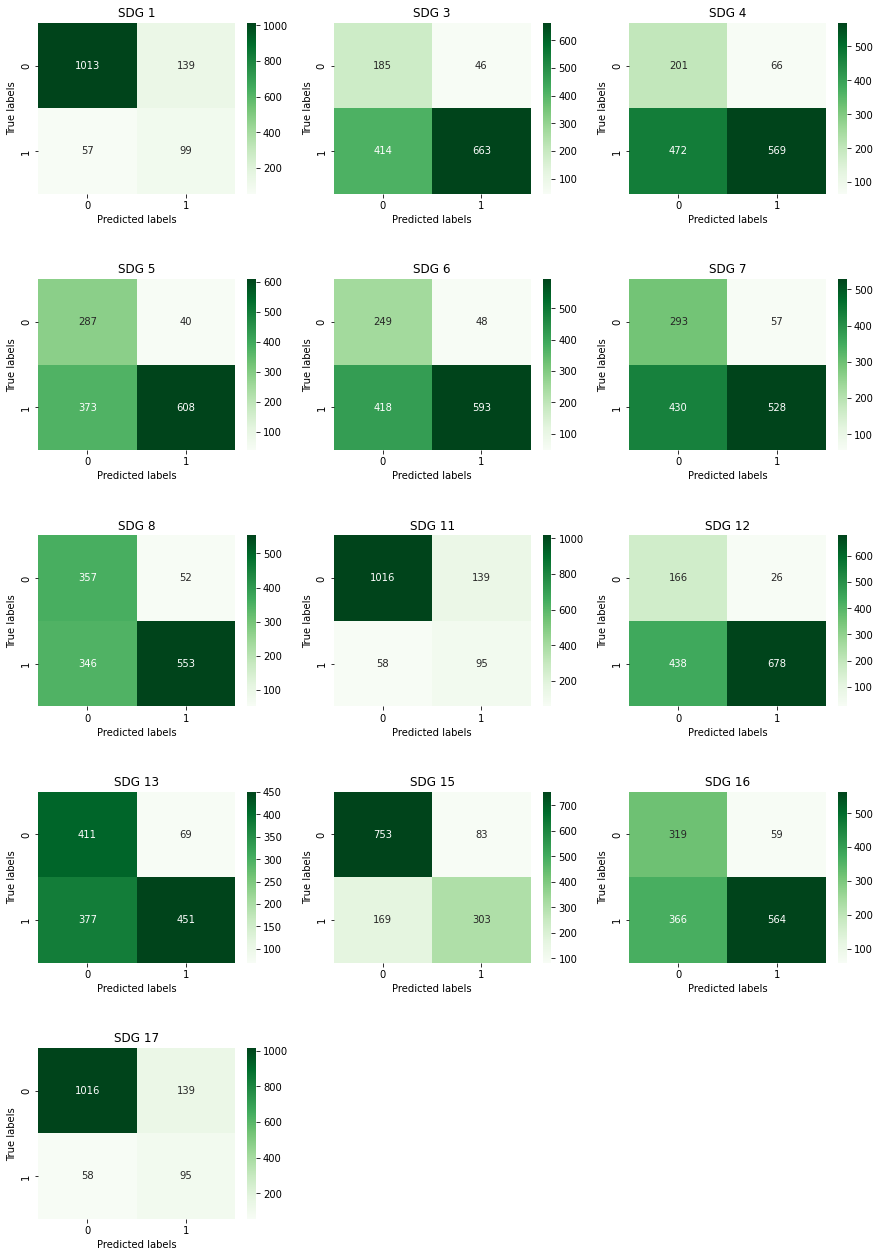

In [91]:
evaluation(grid_svm, X_test, Y_test)

### 2.3. Random Forest

In [92]:
np.random.seed(7)

# Pipeline
pipeline = Pipeline([
    ('clf', OneVsRestClassifier(RandomForestClassifier(class_weight="balanced")))
])
    
# Parameters to test in Grid Search
parameters = {
    'clf__estimator__n_estimators': [50, 100], # Number of trees in the forest
    'clf__estimator__max_depth': [10, 20, None] # Maximum depth of the tree
}

# Use stratified sampling in each iteration
stratified_k_fold_cv = IterativeStratification(n_splits=5, order=1)
# Optimize for macro F1-score
scorer = make_scorer(f1_score, average="macro")

# Grid Search
grid_rf = GridSearchCV(pipeline, parameters, cv=stratified_k_fold_cv, scoring=scorer, n_jobs=8, verbose=3)
grid_rf.fit(X_train, Y_train)

# Print results
print("Best Parameters: {}".format(grid_rf.best_params_))
print("Mean cross-validated F1-score of the best estimator: {}".format(grid_rf.best_score_))

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  26 out of  30 | elapsed:  3.3min remaining:   30.2s
[Parallel(n_jobs=8)]: Done  30 out of  30 | elapsed:  3.3min finished


Best Parameters: {'clf__estimator__max_depth': 10, 'clf__estimator__n_estimators': 100}
Mean cross-validated F1-score of the best estimator: 0.7796079882512076


              precision    recall  f1-score   support

           0       0.78      0.40      0.53       156
           1       0.89      0.84      0.86      1077
           2       0.86      0.84      0.85      1041
           3       0.90      0.80      0.84       981
           4       0.91      0.81      0.86      1011
           5       0.87      0.79      0.83       958
           6       0.89      0.77      0.82       899
           7       0.75      0.41      0.53       153
           8       0.91      0.86      0.89      1116
           9       0.84      0.74      0.78       828
          10       0.82      0.65      0.73       472
          11       0.88      0.75      0.81       930
          12       0.77      0.39      0.52       153

   micro avg       0.88      0.78      0.82      9775
   macro avg       0.85      0.70      0.76      9775
weighted avg       0.88      0.78      0.82      9775
 samples avg       0.81      0.74      0.75      9775



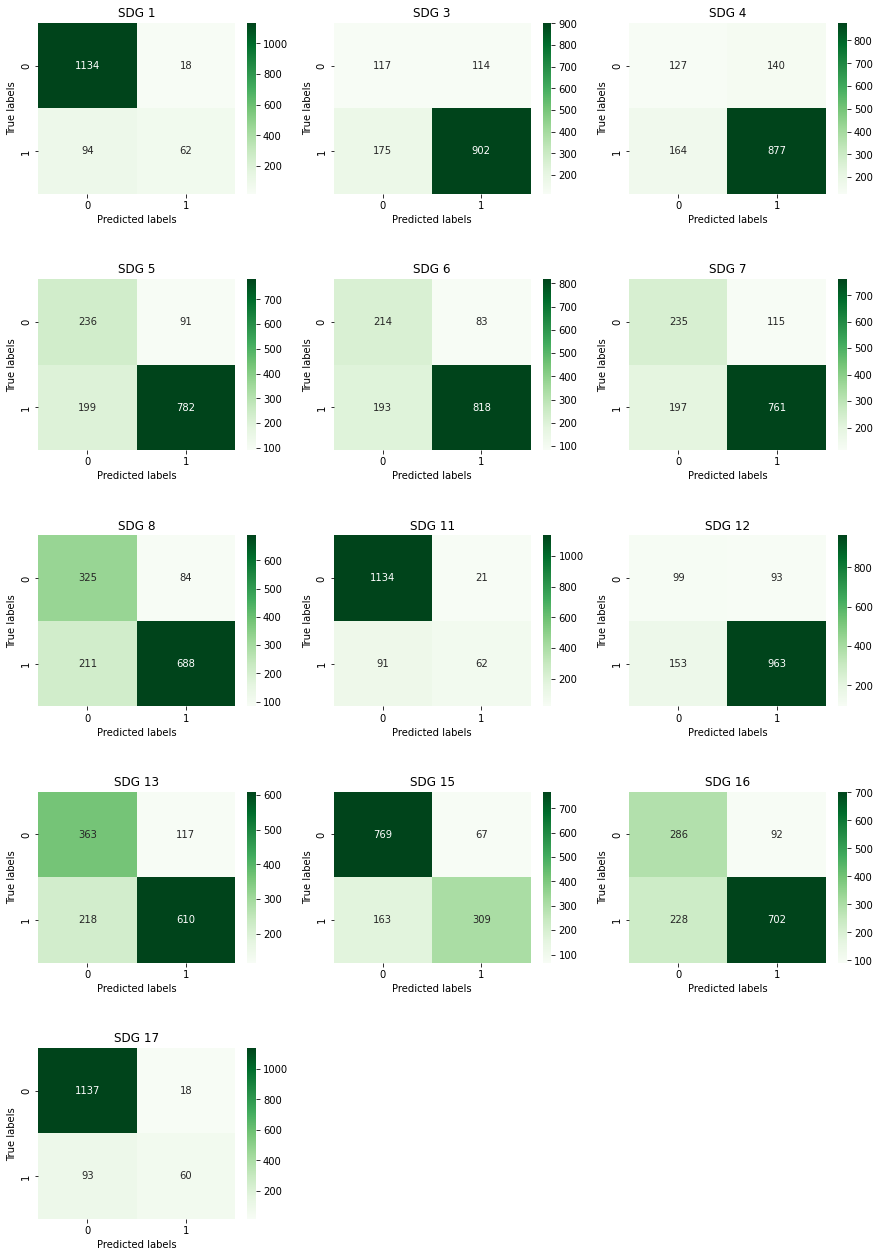

In [93]:
evaluation(grid_rf, X_test, Y_test)

## 3. Classification with SMOTE

### 3.1. KNN

In [94]:
np.random.seed(7)

# Pipeline: Resample data with smote and afterwards pass output to classifier
pipeline = Pipeline([
    ('smote', SMOTE()), 
    ('clf', KNeighborsClassifier())
])

# Transform Y into single labels and pass single label data to different copies of pipeline
ovr = OneVsRestClassifier(pipeline)

# Parameter to test in Grid Search
parameters = {
    'estimator__clf__n_neighbors': [5, 15, 25, 55] # Number of neighbors
}

# Use stratified sampling in each iteration
stratified_k_fold_cv = IterativeStratification(n_splits=5, order=1) 
# Optimize for macro F1-score
scorer = make_scorer(f1_score, average="macro")

# Grid Search
grid_knn = GridSearchCV(ovr, parameters, cv=stratified_k_fold_cv, scoring=scorer, n_jobs=8, verbose=3)
grid_knn.fit(X_train, Y_train)

# Print results
print("Best Parameters: {}".format(grid_knn.best_params_))
print("Mean cross-validated F1-score of the best estimator: {}".format(grid_knn.best_score_))

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  12 out of  20 | elapsed:   42.4s remaining:   28.3s
[Parallel(n_jobs=8)]: Done  20 out of  20 | elapsed:  1.1min finished


Best Parameters: {'estimator__clf__n_neighbors': 5}
Mean cross-validated F1-score of the best estimator: 0.7056824714256752


              precision    recall  f1-score   support

           0       0.30      0.76      0.43       156
           1       0.92      0.69      0.79      1077
           2       0.87      0.66      0.75      1041
           3       0.90      0.64      0.75       981
           4       0.94      0.65      0.77      1011
           5       0.90      0.59      0.72       958
           6       0.86      0.61      0.71       899
           7       0.29      0.70      0.41       153
           8       0.95      0.67      0.78      1116
           9       0.86      0.61      0.71       828
          10       0.67      0.79      0.72       472
          11       0.89      0.62      0.73       930
          12       0.30      0.75      0.43       153

   micro avg       0.80      0.65      0.72      9775
   macro avg       0.74      0.67      0.67      9775
weighted avg       0.86      0.65      0.73      9775
 samples avg       0.75      0.62      0.64      9775



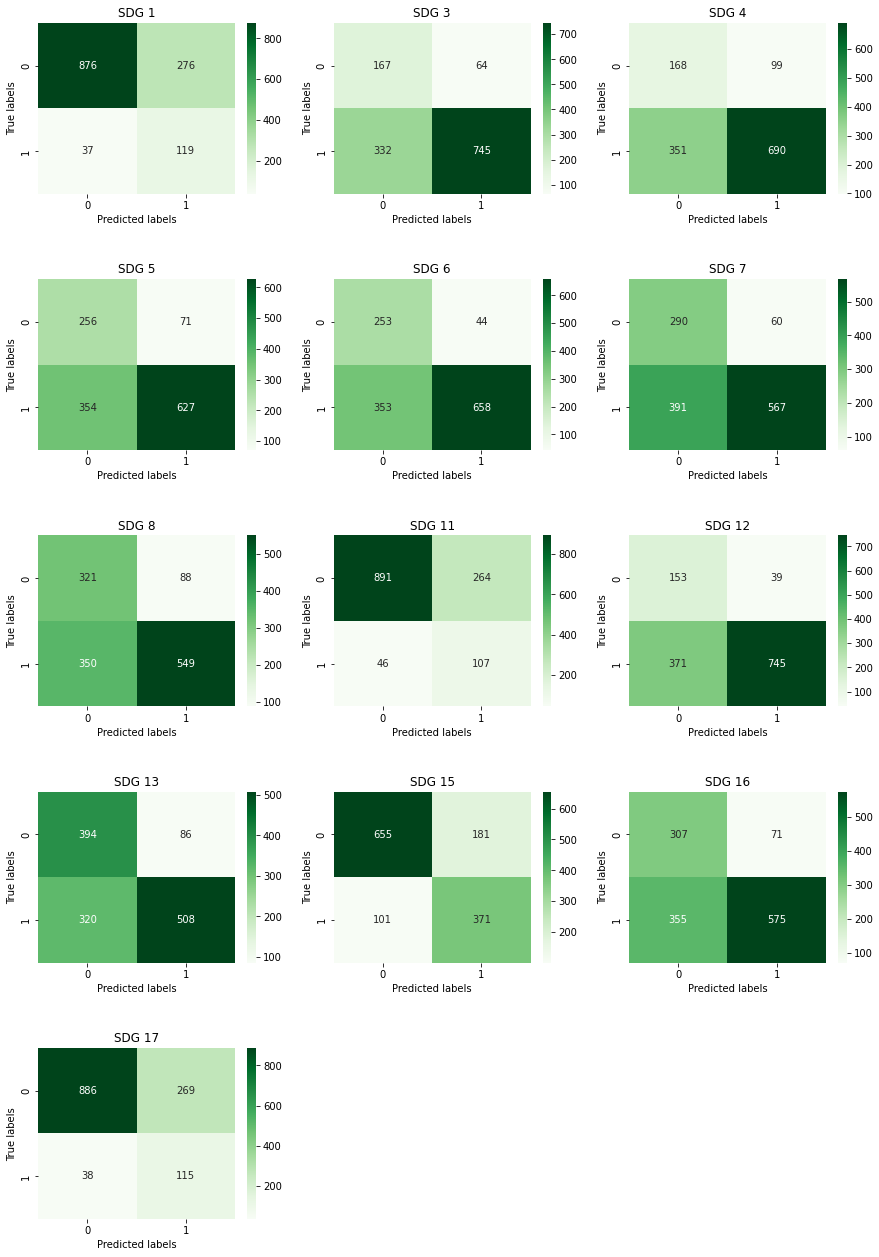

In [95]:
evaluation(grid_knn, X_test, Y_test)

### 3.2. Naive Bayes

In [96]:
np.random.seed(7)

# Pipeline: Resample data with smote and afterwards pass output to classifier
pipeline = Pipeline([
    ('smote', SMOTE()), 
    ('clf', MultinomialNB())
])

# Transform Y into single labels and pass single label data to different copies of pipeline
ovr = OneVsRestClassifier(pipeline)

# Parameter to test in Grid Search
parameters = {
    'estimator__clf__alpha': [0.01, 0.1, 1] # Additive (Laplace/Lidstone) smoothing parameter (0 for no smoothing)
}

# Use stratified sampling in each iteration
stratified_k_fold_cv = IterativeStratification(n_splits=5, order=1) 
# Optimize for macro F1-score
scorer = make_scorer(f1_score, average="macro")

# Grid Search
grid_nb = GridSearchCV(ovr, parameters, cv=stratified_k_fold_cv, scoring=scorer, n_jobs=8, verbose=3)
grid_nb.fit(X_train, Y_train)

# Print results
print("Best Parameters: {}".format(grid_nb.best_params_))
print("Mean cross-validated F1-score of the best estimator: {}".format(grid_nb.best_score_))

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   6 out of  15 | elapsed:    3.3s remaining:    4.9s
[Parallel(n_jobs=8)]: Done  12 out of  15 | elapsed:    6.3s remaining:    1.6s
[Parallel(n_jobs=8)]: Done  15 out of  15 | elapsed:    6.6s finished


Best Parameters: {'estimator__clf__alpha': 0.01}
Mean cross-validated F1-score of the best estimator: 0.692310157979538


              precision    recall  f1-score   support

           0       0.27      0.73      0.40       156
           1       0.88      0.63      0.73      1077
           2       0.83      0.56      0.67      1041
           3       0.87      0.65      0.74       981
           4       0.89      0.73      0.80      1011
           5       0.83      0.71      0.76       958
           6       0.84      0.65      0.74       899
           7       0.26      0.73      0.39       153
           8       0.92      0.76      0.83      1116
           9       0.80      0.64      0.71       828
          10       0.61      0.67      0.64       472
          11       0.84      0.61      0.71       930
          12       0.27      0.74      0.39       153

   micro avg       0.76      0.66      0.71      9775
   macro avg       0.70      0.68      0.65      9775
weighted avg       0.82      0.66      0.72      9775
 samples avg       0.69      0.64      0.62      9775



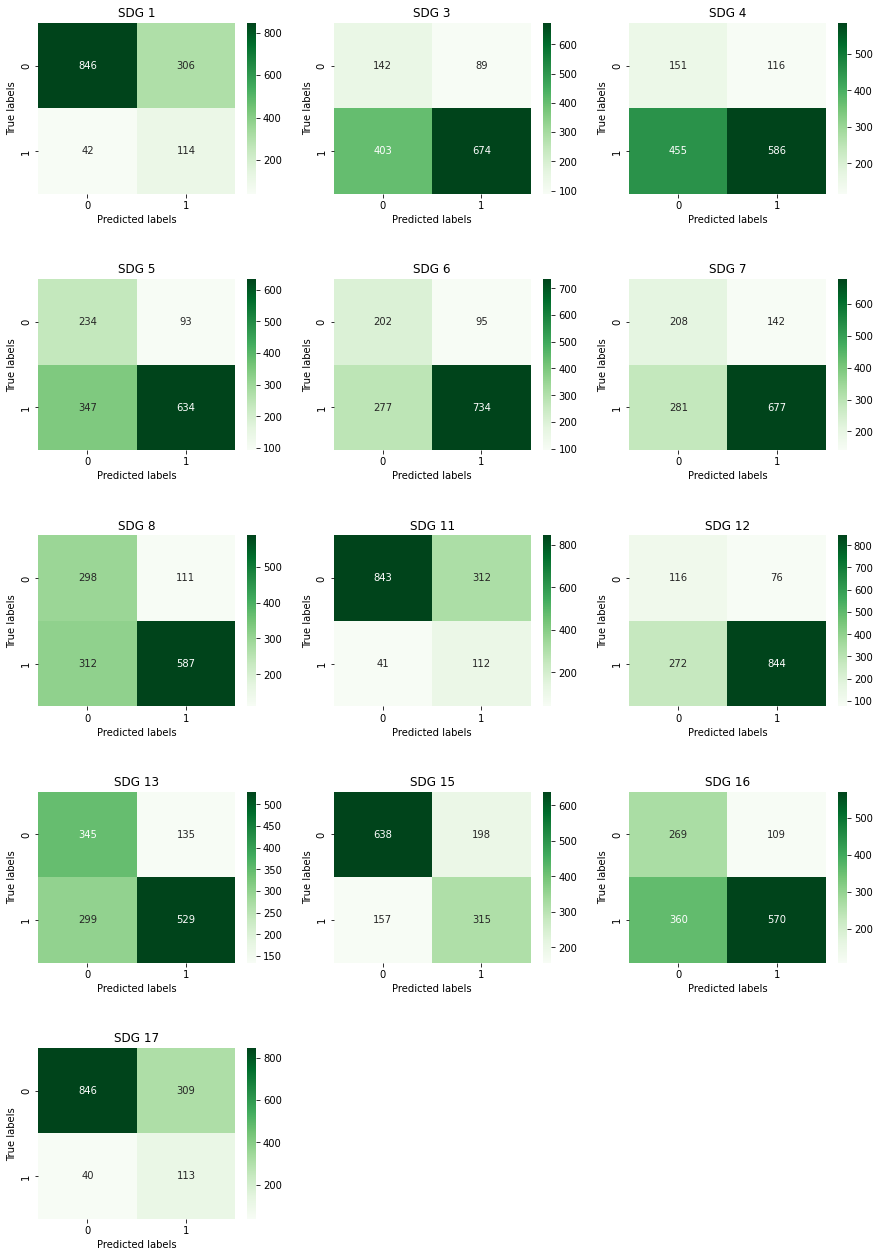

In [97]:
evaluation(grid_nb, X_test, Y_test)

### 3.3. XGBoost

In [98]:
np.random.seed(7)

# Pipeline: Resample data with smote and afterwards pass output to classifier
pipeline = Pipeline([
    ('smote', SMOTE()), 
    ('clf', XGBClassifier())
])

# Transform Y into single labels and pass single label data to different copies of pipeline
ovr = OneVsRestClassifier(pipeline)

# Parameter to test in Grid Search
parameters = {
    'estimator__clf__n_estimators': [50, 100], # Number of boosting rounds
    'estimator__clf__max_depth': [5, 10] # Maximum tree depth for base learners
}

# Use stratified sampling in each iteration
stratified_k_fold_cv = IterativeStratification(n_splits=5, order=1) 
# Optimize for macro F1-score
scorer = make_scorer(f1_score, average="macro")

# Grid Search
grid_xgb = GridSearchCV(ovr, parameters, cv=stratified_k_fold_cv, scoring=scorer, n_jobs=8, verbose=3)
grid_xgb.fit(X_train, Y_train)

# Print results
print("Best Parameters: {}".format(grid_xgb.best_params_))
print("Mean cross-validated F1-score of the best estimator: {}".format(grid_xgb.best_score_))

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
Using TensorFlow backend.
/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is

Using TensorFlow backend.
/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas

Using TensorFlow backend.
/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas

Using TensorFlow backend.
/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas

/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index

/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index

/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index

[CV] clf__estimator__max_depth=10, clf__estimator__n_estimators=100 ..
[CV]  clf__estimator__max_depth=10, clf__estimator__n_estimators=100, score=0.761, total=   8.2s
[CV] clf__estimator__max_depth=20, clf__estimator__n_estimators=50 ...
[CV]  clf__estimator__max_depth=20, clf__estimator__n_estimators=50, score=0.765, total=   5.0s
[CV] clf__estimator__max_depth=None, clf__estimator__n_estimators=50 .
[CV]  clf__estimator__max_depth=None, clf__estimator__n_estimators=50, score=0.767, total=   5.5s
[CV] clf__estimator__max_depth=None, clf__estimator__n_estimators=50 .
[CV]  clf__estimator__max_depth=None, clf__estimator__n_estimators=50, score=0.765, total=   5.5s
[CV] estimator__clf__n_neighbors=5 ...................................
[CV] ....... estimator__clf__n_neighbors=5, score=0.711, total=  19.8s
[CV] estimator__clf__n_neighbors=25 ..................................
[CV] ...... estimator__clf__n_neighbors=25, score=0.637, total=  23.7s
[CV] estimator__clf__alpha=0.01 ...........

/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index

[CV] clf__estimator__max_depth=10, clf__estimator__n_estimators=50 ...
[CV]  clf__estimator__max_depth=10, clf__estimator__n_estimators=50, score=0.758, total=   4.2s
[CV] clf__estimator__max_depth=20, clf__estimator__n_estimators=50 ...
[CV]  clf__estimator__max_depth=20, clf__estimator__n_estimators=50, score=0.781, total=   5.1s
[CV] clf__estimator__max_depth=20, clf__estimator__n_estimators=100 ..
[CV]  clf__estimator__max_depth=20, clf__estimator__n_estimators=100, score=0.779, total=  10.5s
[CV] clf__estimator__max_depth=None, clf__estimator__n_estimators=100 
[CV]  clf__estimator__max_depth=None, clf__estimator__n_estimators=100, score=0.762, total=  10.7s
[CV] estimator__clf__n_neighbors=15 ..................................
[CV] ...... estimator__clf__n_neighbors=15, score=0.651, total=  21.5s
[CV] estimator__clf__n_neighbors=25 ..................................
[CV] ...... estimator__clf__n_neighbors=25, score=0.630, total=  22.5s
[CV] estimator__clf__alpha=0.01 ............

/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index

[CV] clf__estimator__max_depth=10, clf__estimator__n_estimators=100 ..
[CV]  clf__estimator__max_depth=10, clf__estimator__n_estimators=100, score=0.798, total=   8.5s
[CV] clf__estimator__max_depth=20, clf__estimator__n_estimators=100 ..
[CV]  clf__estimator__max_depth=20, clf__estimator__n_estimators=100, score=0.782, total=  10.3s
[CV] clf__estimator__max_depth=None, clf__estimator__n_estimators=100 
[CV]  clf__estimator__max_depth=None, clf__estimator__n_estimators=100, score=0.772, total=  10.5s
[CV] estimator__clf__n_neighbors=5 ...................................
[CV] ....... estimator__clf__n_neighbors=5, score=0.697, total=  20.3s
[CV] estimator__clf__n_neighbors=25 ..................................
[CV] ...... estimator__clf__n_neighbors=25, score=0.641, total=  23.6s
[CV] estimator__clf__alpha=0.01 ......................................
[CV] .......... estimator__clf__alpha=0.01, score=0.689, total=   3.2s
[CV] estimator__clf__alpha=1 .......................................

/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index

[CV] clf__estimator__max_depth=10, clf__estimator__n_estimators=50 ...
[CV]  clf__estimator__max_depth=10, clf__estimator__n_estimators=50, score=0.774, total=   4.2s
[CV] clf__estimator__max_depth=20, clf__estimator__n_estimators=50 ...
[CV]  clf__estimator__max_depth=20, clf__estimator__n_estimators=50, score=0.765, total=   5.0s
[CV] clf__estimator__max_depth=20, clf__estimator__n_estimators=100 ..
[CV]  clf__estimator__max_depth=20, clf__estimator__n_estimators=100, score=0.762, total=  10.0s
[CV] clf__estimator__max_depth=None, clf__estimator__n_estimators=100 
[CV]  clf__estimator__max_depth=None, clf__estimator__n_estimators=100, score=0.769, total=  10.3s
[CV] estimator__clf__n_neighbors=15 ..................................
[CV] ...... estimator__clf__n_neighbors=15, score=0.659, total=  20.9s
[CV] estimator__clf__n_neighbors=25 ..................................
[CV] ...... estimator__clf__n_neighbors=25, score=0.629, total=  21.2s
[CV] estimator__clf__n_neighbors=55 ........

/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index

[CV] clf__estimator__max_depth=10, clf__estimator__n_estimators=50 ...
[CV]  clf__estimator__max_depth=10, clf__estimator__n_estimators=50, score=0.768, total=   4.2s
[CV] clf__estimator__max_depth=20, clf__estimator__n_estimators=50 ...
[CV]  clf__estimator__max_depth=20, clf__estimator__n_estimators=50, score=0.760, total=   5.0s
[CV] clf__estimator__max_depth=20, clf__estimator__n_estimators=100 ..
[CV]  clf__estimator__max_depth=20, clf__estimator__n_estimators=100, score=0.769, total=   9.9s
[CV] clf__estimator__max_depth=None, clf__estimator__n_estimators=100 
[CV]  clf__estimator__max_depth=None, clf__estimator__n_estimators=100, score=0.751, total=  10.2s
[CV] estimator__clf__n_neighbors=5 ...................................
[CV] ....... estimator__clf__n_neighbors=5, score=0.700, total=  19.6s
[CV] estimator__clf__n_neighbors=15 ..................................
[CV] ...... estimator__clf__n_neighbors=15, score=0.640, total=  21.6s
[CV] estimator__clf__n_neighbors=55 ........

/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index

/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index

[CV]  estimator__clf__max_depth=10, estimator__clf__n_estimators=50, score=0.836, total=120.5min
[CV] clf__estimator__max_depth=10, clf__estimator__n_estimators=100 ..
[CV]  clf__estimator__max_depth=10, clf__estimator__n_estimators=100, score=0.778, total=   8.3s
[CV] clf__estimator__max_depth=20, clf__estimator__n_estimators=50 ...
[CV]  clf__estimator__max_depth=20, clf__estimator__n_estimators=50, score=0.767, total=   5.2s
[CV] clf__estimator__max_depth=None, clf__estimator__n_estimators=50 .
[CV]  clf__estimator__max_depth=None, clf__estimator__n_estimators=50, score=0.756, total=   5.4s
[CV] clf__estimator__max_depth=None, clf__estimator__n_estimators=100 
[CV]  clf__estimator__max_depth=None, clf__estimator__n_estimators=100, score=0.764, total=  10.5s
[CV] estimator__clf__n_neighbors=15 ..................................
[CV] ...... estimator__clf__n_neighbors=15, score=0.655, total=  22.1s
[CV] estimator__clf__n_neighbors=55 ..................................
[CV] ...... esti

/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index

[CV] clf__estimator__max_depth=10, clf__estimator__n_estimators=50 ...
[CV]  clf__estimator__max_depth=10, clf__estimator__n_estimators=50, score=0.789, total=   4.2s
[CV] clf__estimator__max_depth=10, clf__estimator__n_estimators=100 ..
[CV]  clf__estimator__max_depth=10, clf__estimator__n_estimators=100, score=0.771, total=   8.2s
[CV] clf__estimator__max_depth=None, clf__estimator__n_estimators=50 .
[CV]  clf__estimator__max_depth=None, clf__estimator__n_estimators=50, score=0.775, total=   5.4s
[CV] clf__estimator__max_depth=None, clf__estimator__n_estimators=50 .
[CV]  clf__estimator__max_depth=None, clf__estimator__n_estimators=50, score=0.772, total=   5.4s
[CV] estimator__clf__n_neighbors=5 ...................................
[CV] ....... estimator__clf__n_neighbors=5, score=0.708, total=  18.7s
[CV] estimator__clf__n_neighbors=15 ..................................
[CV] ...... estimator__clf__n_neighbors=15, score=0.644, total=  20.4s
[CV] estimator__clf__n_neighbors=55 .......

/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index

[11:58:32] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:11:56] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:27:19] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:44:00] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index

[CV] estimator__clf__max_depth=10, estimator__clf__n_estimators=100 ..
[11:57:28] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:10:40] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:25:24] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:42:13] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'l

/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index

[14:40:09] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:42:04] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:44:15] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:43:30] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index

[CV] estimator__clf__max_depth=10, estimator__clf__n_estimators=100 ..
[12:41:34] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:54:08] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:07:35] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:21:06] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'l

              precision    recall  f1-score   support

           0       0.74      0.62      0.67       156
           1       0.88      0.93      0.91      1077
           2       0.85      0.89      0.87      1041
           3       0.88      0.89      0.88       981
           4       0.90      0.87      0.89      1011
           5       0.86      0.85      0.86       958
           6       0.87      0.84      0.86       899
           7       0.69      0.59      0.63       153
           8       0.92      0.91      0.92      1116
           9       0.84      0.80      0.82       828
          10       0.82      0.75      0.79       472
          11       0.86      0.85      0.85       930
          12       0.71      0.59      0.65       153

   micro avg       0.87      0.86      0.86      9775
   macro avg       0.83      0.80      0.81      9775
weighted avg       0.86      0.86      0.86      9775
 samples avg       0.85      0.83      0.82      9775



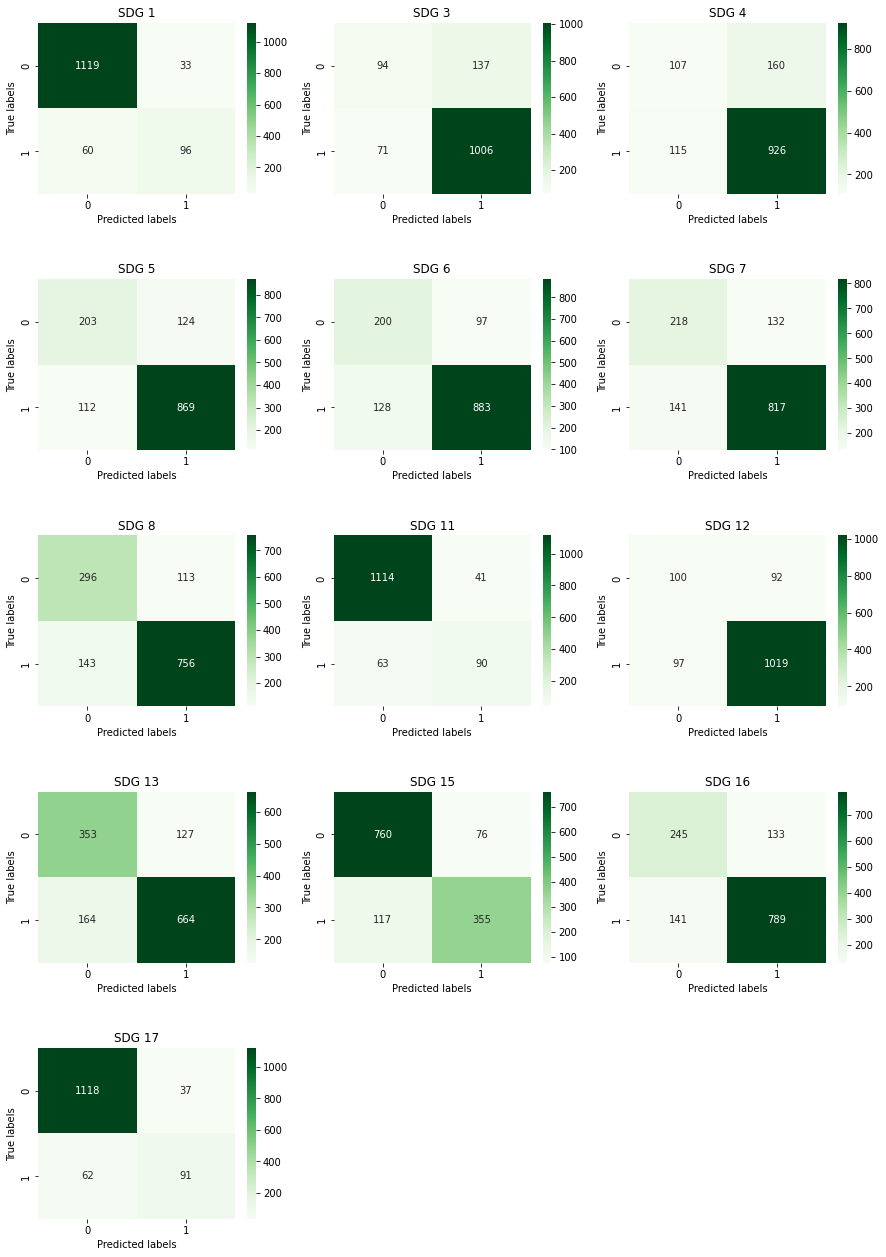

In [99]:
evaluation(grid_xgb, X_test, Y_test)